In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import re
from datetime import datetime

In [ ]:
train_df = pd.read_csv('train_dataset_train.csv')
contract_df = pd.read_csv('type_contract.csv')

# **Обзор датасетов**

In [ ]:
# Тренировочный датасет. id пользователя и его статус

train_df.head()

,contract_id,blocked
0,7780,0
1,7785,0
2,7794,0
3,7795,0
4,7798,0


In [ ]:
train_df.shape

(5992, 2)

In [ ]:
contract_df.head()

,contract_id,day_or_month_contract
0,7780,0
1,7784,0
2,7785,0
3,7794,0
4,7795,1


In [ ]:
contract_df.shape

(6805, 2)

## **Логи днс-запросов к конкурентам**

In [ ]:
named_df = pd.read_csv('named.csv')

In [ ]:
named_df.head(3)

,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335


In [ ]:
named_df.shape

(10646537, 3)

In [ ]:
named_df['url'].value_counts().head(10)

camera.rt.ru                 7333195
vmxott.svc.iptv.rt.ru         289876
tvip-provision.sampo.ru       138944
webmail.sampo.ru              132718
statserv.sampo.ru             110428
193755.16.rt.ru               106464
_sip._udp.193755.16.rt.ru     104596
_sip._tcp.193755.16.rt.ru     101820
530237.16.rt.ru                99694
048056.16.rt.ru                98511
Name: url, dtype: int64

In [ ]:
named_df.groupby('url')['contract_id'].nunique().sort_values(ascending = False).head(25)

url
camera.rt.ru                    192860
vmxott.svc.iptv.rt.ru           148509
tvip-provision.sampo.ru          98897
webmail.sampo.ru                 95182
statserv.sampo.ru                82322
193755.16.rt.ru                  81830
_sip._udp.193755.16.rt.ru        80868
_sip._tcp.193755.16.rt.ru        79149
530237.16.rt.ru                  77750
048056.16.rt.ru                  77295
_sip._udp.048056.16.rt.ru        76949
st44-broadcast.sampo.ru          58789
fe-nw.svc.iptv.rt.ru             56525
sz-ptzv-itv02.svc.iptv.rt.ru     53725
navigator.sampo.ru               53517
_sip._udp.173428.16.rt.ru        53089
173428.16.rt.ru                  46567
_sip._tcp.173428.16.rt.ru        45042
fnc.rt.ru                        44096
acs.rt.ru                        41692
moigorod.sampo.ru                40948
swap.sampo.ru                    39808
sampo.ru                         37085
sz-ptzv-itv01.svc.iptv.rt.ru     36206
lk.sampo.ru                      31614
Name: contract_id, dt

***Столбец с разделением по домену  - rt или sampo.***

In [ ]:
named_df.loc[named_df['url'].str.contains('sampo.', flags = re.I), 'domain'] = 'sampo'
named_df.loc[named_df['url'].str.contains('rt.', flags = re.I), 'domain'] = 'rt'

named_df['domain'].isnull().sum()

In [ ]:
named_df['domain'].value_counts()

rt       9313702
sampo    1332835
Name: domain, dtype: int64

In [ ]:
# Ранее было видно, что количество посещений "camera.rt.ru" в несколько десятков раз выше, чем по остальным ссылкам.
# Ниже представлена частота посщений без учета "camera.rt.ru"

named_df.query("url!='camera.rt.ru'")['domain'].value_counts()

rt       1980507
sampo    1332835
Name: domain, dtype: int64

In [ ]:
named_df.groupby('domain')['contract_id'].nunique()

domain
rt       195364
sampo    194778
Name: contract_id, dtype: int64

***Столбец с разделением по дню недели  - рабочий или выходной.***

In [ ]:
named_df['date'] = pd.to_datetime(named_df['date'])

named_df['weekday'] = named_df['date'].dt.weekday
named_df.loc[named_df['weekday'].isin([5, 6]), 'weekday'] = 'weekend'
named_df.loc[named_df['weekday'].isin([0, 1, 2, 3, 4]), 'weekday'] = 'working'

named_df['weekday'].isnull().sum()

0

In [ ]:
named_df['weekday'].value_counts()

working    7708365
weekend    2938172
Name: weekday, dtype: int64

***Формирование сводной таблицы по абонентам.***

In [ ]:
# Общее количество посещений.

visits_freq = named_df.query("url!='camera.rt.ru'").groupby('contract_id', as_index = False)['url'].count()\
                                                    .rename(columns = {'url': 'visits_freq'})
visits_freq.head()

,contract_id,visits_freq
0,7780,83
1,7785,10
2,7799,1
3,7805,2
4,7807,1


In [ ]:
# Количество посещений в зависимости от дня недели.

named_df['for_counting'] = 1
visits_by_days = pd.pivot_table(named_df.query("url!='camera.rt.ru'"), index = 'contract_id', columns = ['weekday'],
                                values = ['for_counting'], aggfunc = np.sum, fill_value = 0).reset_index()

In [ ]:
summary_by_visits = visits_freq.merge(visits_by_days, on = 'contract_id')
summary_by_visits.rename(columns = {('for_counting', 'weekend'): 'visits_weekend', 
                                    ('for_counting', 'working'): 'visits_working'}, inplace = True)

summary_by_visits.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  validate=validate,
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,contract_id,visits_freq,visits_weekend,visits_working
0,7780,83,0,83
1,7785,10,7,3
2,7799,1,0,1
3,7805,2,0,2
4,7807,1,0,1


In [ ]:
# Какое количество дней абонент посещал домены конкурентов.

active_days = named_df.groupby('contract_id', as_index = False)['date'].nunique()\
                      .rename(columns = {'date': 'visit_days'})

summary_by_visits = summary_by_visits.merge(active_days, on = 'contract_id')
summary_by_visits.head()

,contract_id,visits_freq,visits_weekend,visits_working,visit_days
0,7780,83,0,83,2
1,7785,10,7,3,3
2,7799,1,0,1,1
3,7805,2,0,2,2
4,7807,1,0,1,1


In [ ]:
# Количество уникальных url-адресов, которые посетил клиент.

unique_urls = named_df.groupby('contract_id', as_index = False)['url'].nunique()\
                      .rename(columns = {'url': 'visits_unique'})

summary_by_visits = summary_by_visits.merge(unique_urls, on = 'contract_id')
summary_by_visits.head()

,contract_id,visits_freq,visits_weekend,visits_working,visit_days,visits_unique
0,7780,83,0,83,2,26
1,7785,10,7,3,3,5
2,7799,1,0,1,1,1
3,7805,2,0,2,2,1
4,7807,1,0,1,1,1


In [ ]:
# Количество посещений в зависимости от домена - rt или sampo.

quantity_by_domain = pd.pivot_table(named_df.query("url!='camera.rt.ru'"), index = 'contract_id', columns = ['domain'],
                                    values = ['for_counting'], aggfunc = np.sum, fill_value = 0).reset_index()

summary_by_visits = summary_by_visits.merge(quantity_by_domain, on = 'contract_id')

summary_by_visits.rename(columns = {('for_counting', 'rt'): 'visits_rt', 
                                     ('for_counting', 'sampo'): 'visits_sampo'}, inplace = True)

summary_by_visits.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  validate=validate,
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,contract_id,visits_freq,visits_weekend,visits_working,visit_days,visits_unique,visits_rt,visits_sampo
0,7780,83,0,83,2,26,2,81
1,7785,10,7,3,3,5,3,7
2,7799,1,0,1,1,1,0,1
3,7805,2,0,2,2,1,2,0
4,7807,1,0,1,1,1,0,1


In [ ]:
# Количество уникальных url-адресов в зависимости от домена

unique_rt_urls = named_df.query("domain=='rt'").groupby('contract_id', as_index = False)['url'].nunique()\
                         .rename(columns = {'url': 'visits_unique_rt'})

summary_by_visits = summary_by_visits.merge(unique_rt_urls, how = 'left', on = 'contract_id')
summary_by_visits.fillna(0, inplace = True)
summary_by_visits['visits_unique_sampo'] = summary_by_visits['visits_unique'] - summary_by_visits['visits_unique_rt']

summary_by_visits.head()

,contract_id,visits_freq,visits_weekend,visits_working,visit_days,visits_unique,visits_rt,visits_sampo,visits_unique_rt,visits_unique_sampo
0,7780,83,0,83,2,26,2,81,1.0,25.0
1,7785,10,7,3,3,5,3,7,1.0,4.0
2,7799,1,0,1,1,1,0,1,0.0,1.0
3,7805,2,0,2,2,1,2,0,1.0,0.0
4,7807,1,0,1,1,1,0,1,0.0,1.0


In [ ]:
rt_camera_freq = named_df.query("url=='camera.rt.ru'").groupby('contract_id', as_index = False)['url'].count()\
                                                      .rename(columns = {'url': 'rt_camera_freq'})

summary_by_visits = summary_by_visits.merge(rt_camera_freq, how = 'left', on = 'contract_id')
summary_by_visits.fillna(0, inplace = True)

In [ ]:
summary_by_visits.describe().iloc[1:, 1:].round(2)

,visits_freq,visits_weekend,visits_working,visit_days,visits_unique,visits_rt,visits_sampo,visits_unique_rt,visits_unique_sampo,rt_camera_freq
mean,16.89,4.60,12.30,27.19,14.67,10.10,6.80,9.10,5.57,37.39
std,37.04,11.44,26.51,3.92,3.53,25.98,26.13,2.63,2.28,7.83
min,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00
25%,14.00,3.00,9.00,26.00,13.00,8.00,5.00,7.00,4.00,34.00
50%,16.00,4.00,12.00,28.00,15.00,10.00,6.00,9.00,5.00,38.00
75%,19.00,6.00,14.00,29.00,17.00,12.00,8.00,11.00,7.00,42.00
max,6934.00,2305.00,5564.00,35.00,71.00,6922.00,6627.00,52.00,70.00,76.00


In [ ]:
nn_quantiles = [summary_by_visits[i].quantile(0.99) for i in summary_by_visits.columns[1:]]

In [ ]:
describe_df = summary_by_visits.describe().iloc[1:, 1:].T.round(2)
describe_df.insert(6, '99%', nn_quantiles)
describe_df

,mean,std,min,25%,50%,75%,99%,max
visits_freq,16.89,37.04,1.0,14.0,16.0,19.0,27.0,6934.0
visits_weekend,4.60,11.44,0.0,3.0,4.0,6.0,10.0,2305.0
visits_working,12.30,26.51,0.0,9.0,12.0,14.0,21.0,5564.0
visit_days,27.19,3.92,1.0,26.0,28.0,29.0,33.0,35.0
visits_unique,14.67,3.53,1.0,13.0,15.0,17.0,23.0,71.0
visits_rt,10.10,25.98,0.0,8.0,10.0,12.0,18.0,6922.0
visits_sampo,6.80,26.13,0.0,5.0,6.0,8.0,13.0,6627.0
visits_unique_rt,9.10,2.63,0.0,7.0,9.0,11.0,15.0,52.0
visits_unique_sampo,5.57,2.28,0.0,4.0,5.0,7.0,11.0,70.0
rt_camera_freq,37.39,7.83,0.0,34.0,38.0,42.0,53.0,76.0


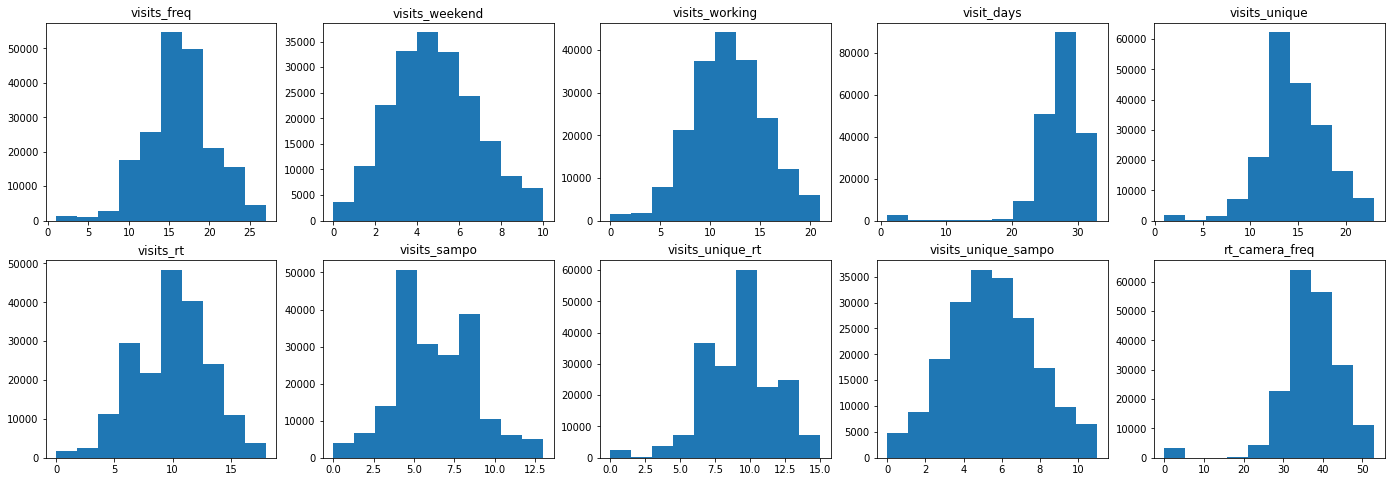

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (24, 8))
for i in range(2):
  for j in range(5):
    ax = axes[i][j]
    if i == 0:
      feature = summary_by_visits.columns[1:][j]
      values = summary_by_visits.query(f'{feature}<={nn_quantiles[j]}')[feature]
      ax.hist(values)
      ax.set_title(feature)
    else:
      feature = summary_by_visits.columns[1:][j+5]
      values = summary_by_visits.query(f'{feature}<={nn_quantiles[j+5]}')[feature]
      ax.hist(values)
      ax.set_title(feature)

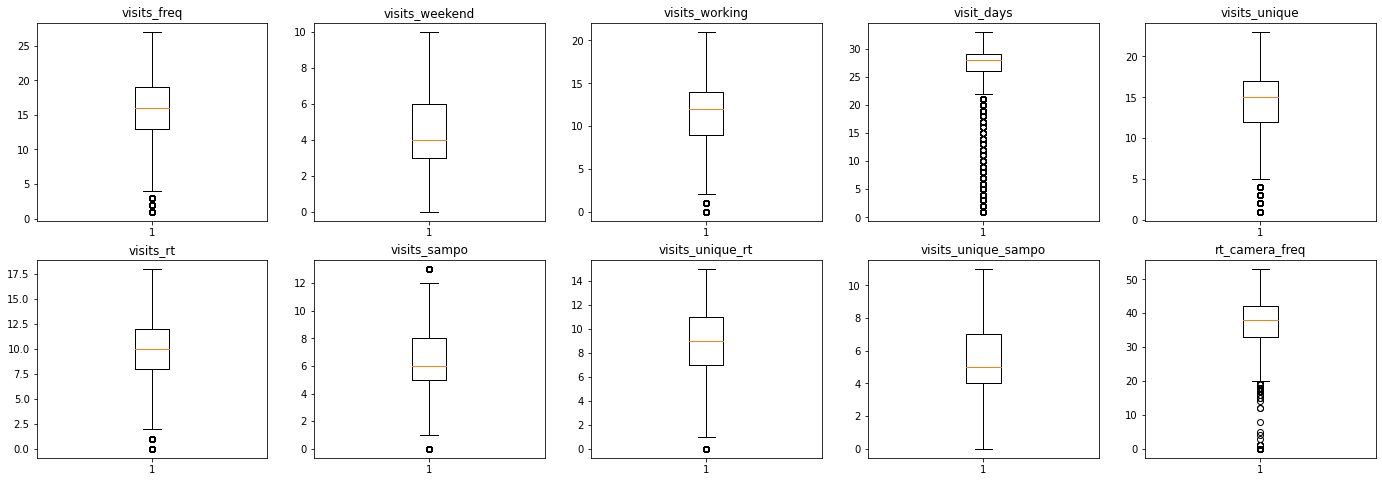

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (24, 8))
for i in range(2):
  for j in range(5):
    ax = axes[i][j]
    if i == 0:
      feature = summary_by_visits.columns[1:][j]
      values = summary_by_visits.query(f'{feature}<={nn_quantiles[j]}')[feature]
      ax.boxplot(values)
      ax.set_title(feature)
    else:
      feature = summary_by_visits.columns[1:][j+5]
      values = summary_by_visits.query(f'{feature}<={nn_quantiles[j+5]}')[feature]
      ax.boxplot(values)
      ax.set_title(feature)

In [ ]:
summary_by_visits.to_excel('сводная_логи_конкуренты.xlsx')

## **Логи запросов к своему провайдеру**

In [ ]:
log_df = pd.read_csv('log.csv')
log_df.head()

,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах


In [ ]:
log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25274 entries, 0 to 25273
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   contract_id  25274 non-null  int64 
 1   event_date   25274 non-null  object
 2   event_type   25274 non-null  object
dtypes: int64(1), object(2)
memory usage: 592.5+ KB


In [ ]:
# Количество обращений по типу запроса

log_df['event_type'].value_counts().head(10)

Информер ВК. Показ                       8001
Включение интернета на 20 минут          4092
Обращение в службу заботы о клиентах     2860
Гарантированный платеж за деньги         2679
Виртуальное бессмертие. Использование     757
Турбокнопка бесплатно                     546
Включение интернета на 20 минут с IVR     343
Смена тарифа                              335
Состояние клиентского оборудования        311
Смена пароля                              283
Name: event_type, dtype: int64

In [ ]:
log_df['contract_id'].nunique()

4311

***Столбец с разделением по дню недели  - рабочий или выходной (+ время суток)***

In [ ]:
log_df['event_date'] = pd.to_datetime(log_df['event_date'])
log_df['weekday'] = log_df['event_date'].dt.weekday

log_df.loc[log_df['weekday'].isin([5, 6]), 'weekday'] = 'weekend'
log_df.loc[log_df['weekday'].isin([0, 1, 2, 3, 4]), 'weekday'] = 'working'

In [ ]:
log_df['weekday'].value_counts()

working    18668
weekend     6606
Name: weekday, dtype: int64

In [ ]:
log_df['weekday'].isnull().sum()

0

In [ ]:
log_df['time'] = log_df['event_date'].dt.time
log_df['time'] = log_df['time'].apply(lambda x: str(x))

log_df.loc[(log_df['time'] > '06:00:00') & (log_df['time'] <= '12:00:00'), 
           'time_of_day'] = 'morning'
log_df.loc[(log_df['time'] > '12:00:00') & (log_df['time'] <= '18:00:00'), 
           'time_of_day'] = 'daytime'
log_df.loc[(log_df['time'] > '18:00:00') & (log_df['time'] <= '23:59:59'), 
           'time_of_day'] = 'evening'
log_df.loc[(log_df['time'] > '00:00:00') & (log_df['time'] <= '06:00:00'), 
           'time_of_day'] = 'night'           

log_df = log_df.drop('time', axis = 1)
log_df.head()

,contract_id,event_date,event_type,weekday,time_of_day
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров,weekend,daytime
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах,weekend,daytime
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета,weekend,daytime
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета,weekend,daytime
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах,weekend,daytime


In [ ]:
log_df['time_of_day'].value_counts()

evening    10640
daytime     8720
morning     4473
night       1441
Name: time_of_day, dtype: int64

In [ ]:
log_df['time_of_day'].isnull().sum()

0

***Формирование сводной таблицы по клиентам***

In [ ]:
# Частота обращений и число уникальных обращений

summary_by_requests = log_df.groupby('contract_id', as_index = False)['event_type'].agg(['count', 'nunique'])\
                            .rename(columns = {'count': 'requests_freq', 'nunique': 'requests_unique'})

summary_by_requests.head()

,requests_freq,requests_unique
contract_id,,
7780,9,4
7785,1,1
7795,7,2
7798,3,1
7805,8,4


In [ ]:
# Количество дней, когда клиент обращался с запросом.

log_df['event_date'] = log_df['event_date'].astype('datetime64[D]')
request_days= log_df.groupby('contract_id', as_index = False)['event_date'].nunique()\
                    .rename(columns = {'event_date': 'request_days'})

summary_by_requests = summary_by_requests.merge(request_days, how = 'left', on = 'contract_id')
summary_by_requests.head()

,contract_id,requests_freq,requests_unique,request_days
0,7780,9,4,5
1,7785,1,1,1
2,7795,7,2,4
3,7798,3,1,2
4,7805,8,4,3


In [ ]:
# Частота обращений в рабочие и выходные дни.

log_df['for_counting'] = 1

requests_by_days = pd.pivot_table(log_df, index = 'contract_id', columns = ['weekday'],
                                  values = ['for_counting'], aggfunc = np.sum, fill_value = 0).reset_index()

summary_by_requests = summary_by_requests.merge(requests_by_days, how = 'left', on = 'contract_id')
summary_by_requests.rename(columns = {('for_counting', 'weekend'): 'requests_weekend', 
                                     ('for_counting', 'working'): 'requests_working'}, inplace = True)


requests_by_timeOfDay = pd.pivot_table(log_df, index = 'contract_id', columns = ['time_of_day'],
                                       values = ['for_counting'], aggfunc = np.sum, fill_value = 0).reset_index()

summary_by_requests = summary_by_requests.merge(requests_by_timeOfDay, how = 'left', on = 'contract_id')
summary_by_requests.rename(columns = {('for_counting', 'daytime'): 'requests_daytime', 
                                      ('for_counting', 'evening'): 'requests_evening', 
                                      ('for_counting', 'morning'): 'requests_morning',
                                      ('for_counting', 'night'): 'requests_night'}, inplace = True)

summary_by_requests.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  validate=validate,
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,contract_id,requests_freq,requests_unique,request_days,requests_weekend,requests_working,requests_daytime,requests_evening,requests_morning,requests_night
0,7780,9,4,5,2,7,7,0,2,0
1,7785,1,1,1,0,1,0,1,0,0
2,7795,7,2,4,2,5,0,7,0,0
3,7798,3,1,2,3,0,2,1,0,0
4,7805,8,4,3,1,7,4,2,2,0


In [ ]:
care_service = log_df.query("event_type=='Обращение в службу заботы о клиентах'")
care_service_freq = care_service.groupby('contract_id', as_index = False)['event_type'].count()\
                                .rename(columns = {'event_type': 'care_service'})

summary_by_requests = summary_by_requests.merge(care_service_freq, how = 'left', on = 'contract_id')
summary_by_requests.fillna(0, inplace = True)
summary_by_requests.head()

,contract_id,requests_freq,requests_unique,request_days,requests_weekend,requests_working,requests_daytime,requests_evening,requests_morning,requests_night,care_service
0,7780,9,4,5,2,7,7,0,2,0,3.0
1,7785,1,1,1,0,1,0,1,0,0,0.0
2,7795,7,2,4,2,5,0,7,0,0,0.0
3,7798,3,1,2,3,0,2,1,0,0,0.0
4,7805,8,4,3,1,7,4,2,2,0,2.0


In [ ]:
summary_by_requests.describe().iloc[1:, 1:]

,requests_freq,requests_unique,request_days,requests_weekend,requests_working,requests_daytime,requests_evening,requests_morning,requests_night,care_service
mean,5.862677,2.691023,3.350499,1.532359,4.330318,2.022733,2.468105,1.037578,0.334261,0.663419
std,9.238057,2.212936,3.906785,3.023007,7.028045,3.964101,4.166805,2.785941,1.224966,1.456135
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,7.000000,3.000000,4.000000,2.000000,5.000000,3.000000,3.000000,1.000000,0.000000,1.000000
max,354.000000,17.000000,59.000000,104.000000,250.000000,140.000000,123.000000,93.000000,20.000000,27.000000


In [ ]:
nn_quantiles = [summary_by_requests[i].quantile(0.99) for i in summary_by_requests.columns[1:]]

In [ ]:
describe_df = summary_by_requests.describe().iloc[1:, 1:].T.round(2)
describe_df.insert(6, '99%', nn_quantiles)
describe_df

,mean,std,min,25%,50%,75%,99%,max
requests_freq,5.86,9.24,1.0,2.0,4.0,7.0,17.0,354.0
requests_unique,2.69,2.21,1.0,1.0,2.0,3.0,7.0,17.0
request_days,3.35,3.91,1.0,1.0,2.0,4.0,10.0,59.0
requests_weekend,1.53,3.02,0.0,0.0,1.0,2.0,6.0,104.0
requests_working,4.33,7.03,0.0,1.0,3.0,5.0,13.0,250.0
requests_daytime,2.02,3.96,0.0,0.0,1.0,3.0,7.0,140.0
requests_evening,2.47,4.17,0.0,0.0,1.0,3.0,9.0,123.0
requests_morning,1.04,2.79,0.0,0.0,0.0,1.0,4.0,93.0
requests_night,0.33,1.22,0.0,0.0,0.0,0.0,2.0,20.0
care_service,0.66,1.46,0.0,0.0,0.0,1.0,3.0,27.0


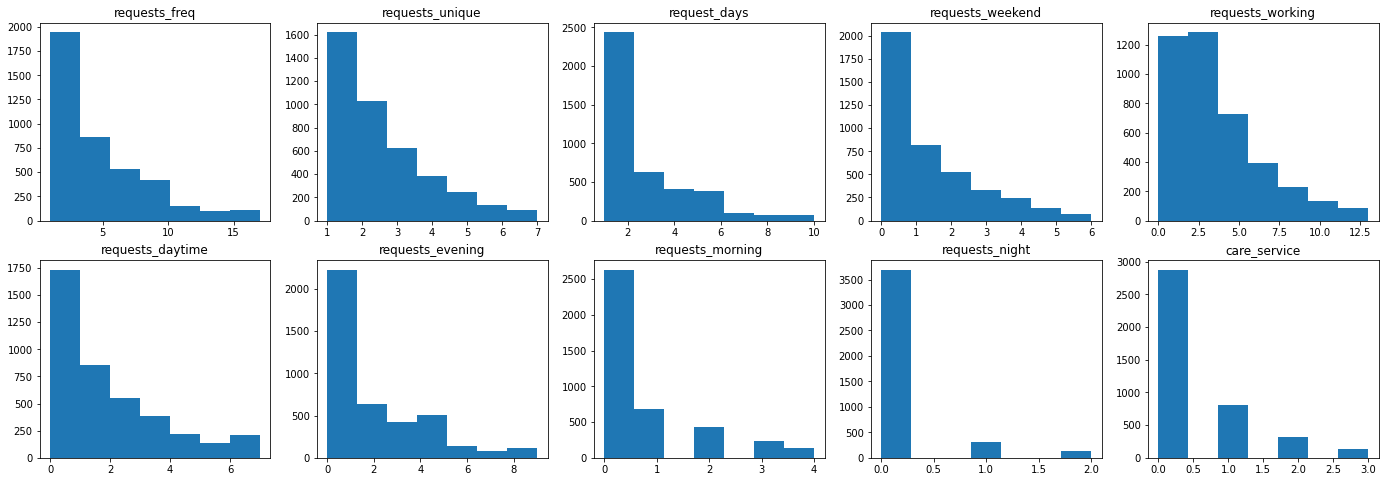

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (24, 8))
for i in range(2):
  for j in range(5):
    ax = axes[i][j]
    if i == 0:
      feature = summary_by_requests.columns[1:][j]
      values = summary_by_requests.query(f'{feature}<={nn_quantiles[j]}')[feature]
      ax.hist(values, bins = 7)
      ax.set_title(feature)
    else:
      feature = summary_by_requests.columns[1:][j+5]
      values = summary_by_requests.query(f'{feature}<={nn_quantiles[j+5]}')[feature]
      ax.hist(values, bins = 7)
      ax.set_title(feature)